In [1]:
import sys
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.analysis.emission_lines as oxygen_lines
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.const as const

In [2]:
sds = specds.load_dataset('SN2019odp')

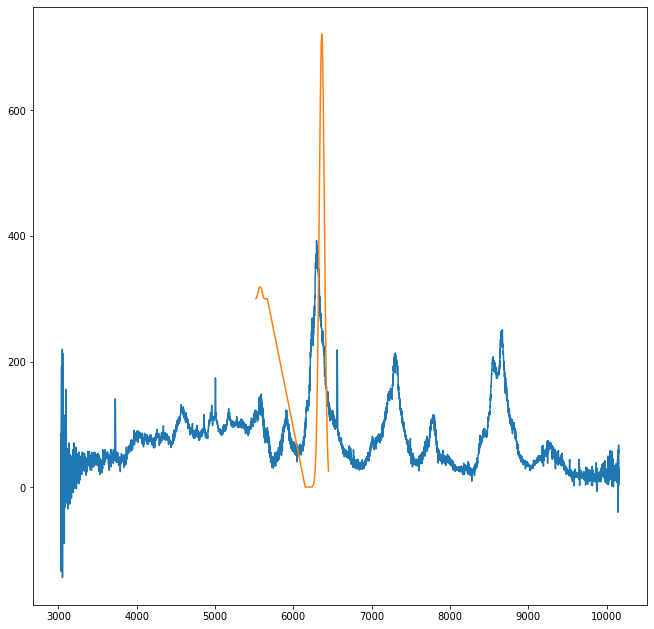

In [3]:
plt.figure(figsize=(11,11))
#spec = sds['ZTF19abqwtfu_20200821_Keck1_v1.ascii']
spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
spec = spec[~np.isnan(spec['flux'])]


cfg = oxygen_lines.FitSetup(spec=spec,
                            model='1_free',
                            start5577=5520,
                            stop5577=5669,
                            start6300_6364=6150,
                            stop6300_6364=6450,
                            redshift=const.redshift,
                            redshift_err=const.redshift_err,
                            scale_factor=1e18
                           )
spec_wave = np.array(cfg.spec['restwave'], copy=True)
grp_5577 = np.logical_and(spec_wave > cfg.start5577, spec_wave < cfg.stop5577)
grp_6300_6364 = np.logical_and(spec_wave > cfg.start6300_6364, spec_wave < cfg.stop6300_6364)
idx = np.logical_or(grp_5577, grp_6300_6364)
sf = cfg.scale_factor

plt.plot(spec['restwave'], spec['flux']*sf)

p = np.array([300/sf, 0.001/sf, 0, 0.001/sf, np.exp(3.5), np.exp(7)/sf, 1/sf, np.exp(11)/sf])
plt.plot(spec['restwave'][idx], sf*oxygen_lines.model1_free(p, spec['restwave'][idx], grp_5577[idx], grp_6300_6364[idx]))

In [4]:

cfg = oxygen_lines.FitSetup(spec=spec,
                            model='1_free',
                            start5577=5520,
                            stop5577=5669,
                            start6300_6364=6150,
                            stop6300_6364=6450,
                            redshift=const.redshift,
                            redshift_err=const.redshift_err,
                            scale_factor=1e18
                           )

sampler = oxygen_lines.setup_dynesty_sampler(cfg)

In [5]:
sampler.run_nested()

74611it [05:01, 247.51it/s, +2000 | bound: 411 | nc: 1 | ncall: 1759402 | eff(%):  4.354 | loglstar:   -inf < -1334.094 <    inf | logz: -1372.823 +/-  0.266 | dlogz:  0.002 >  2.009]


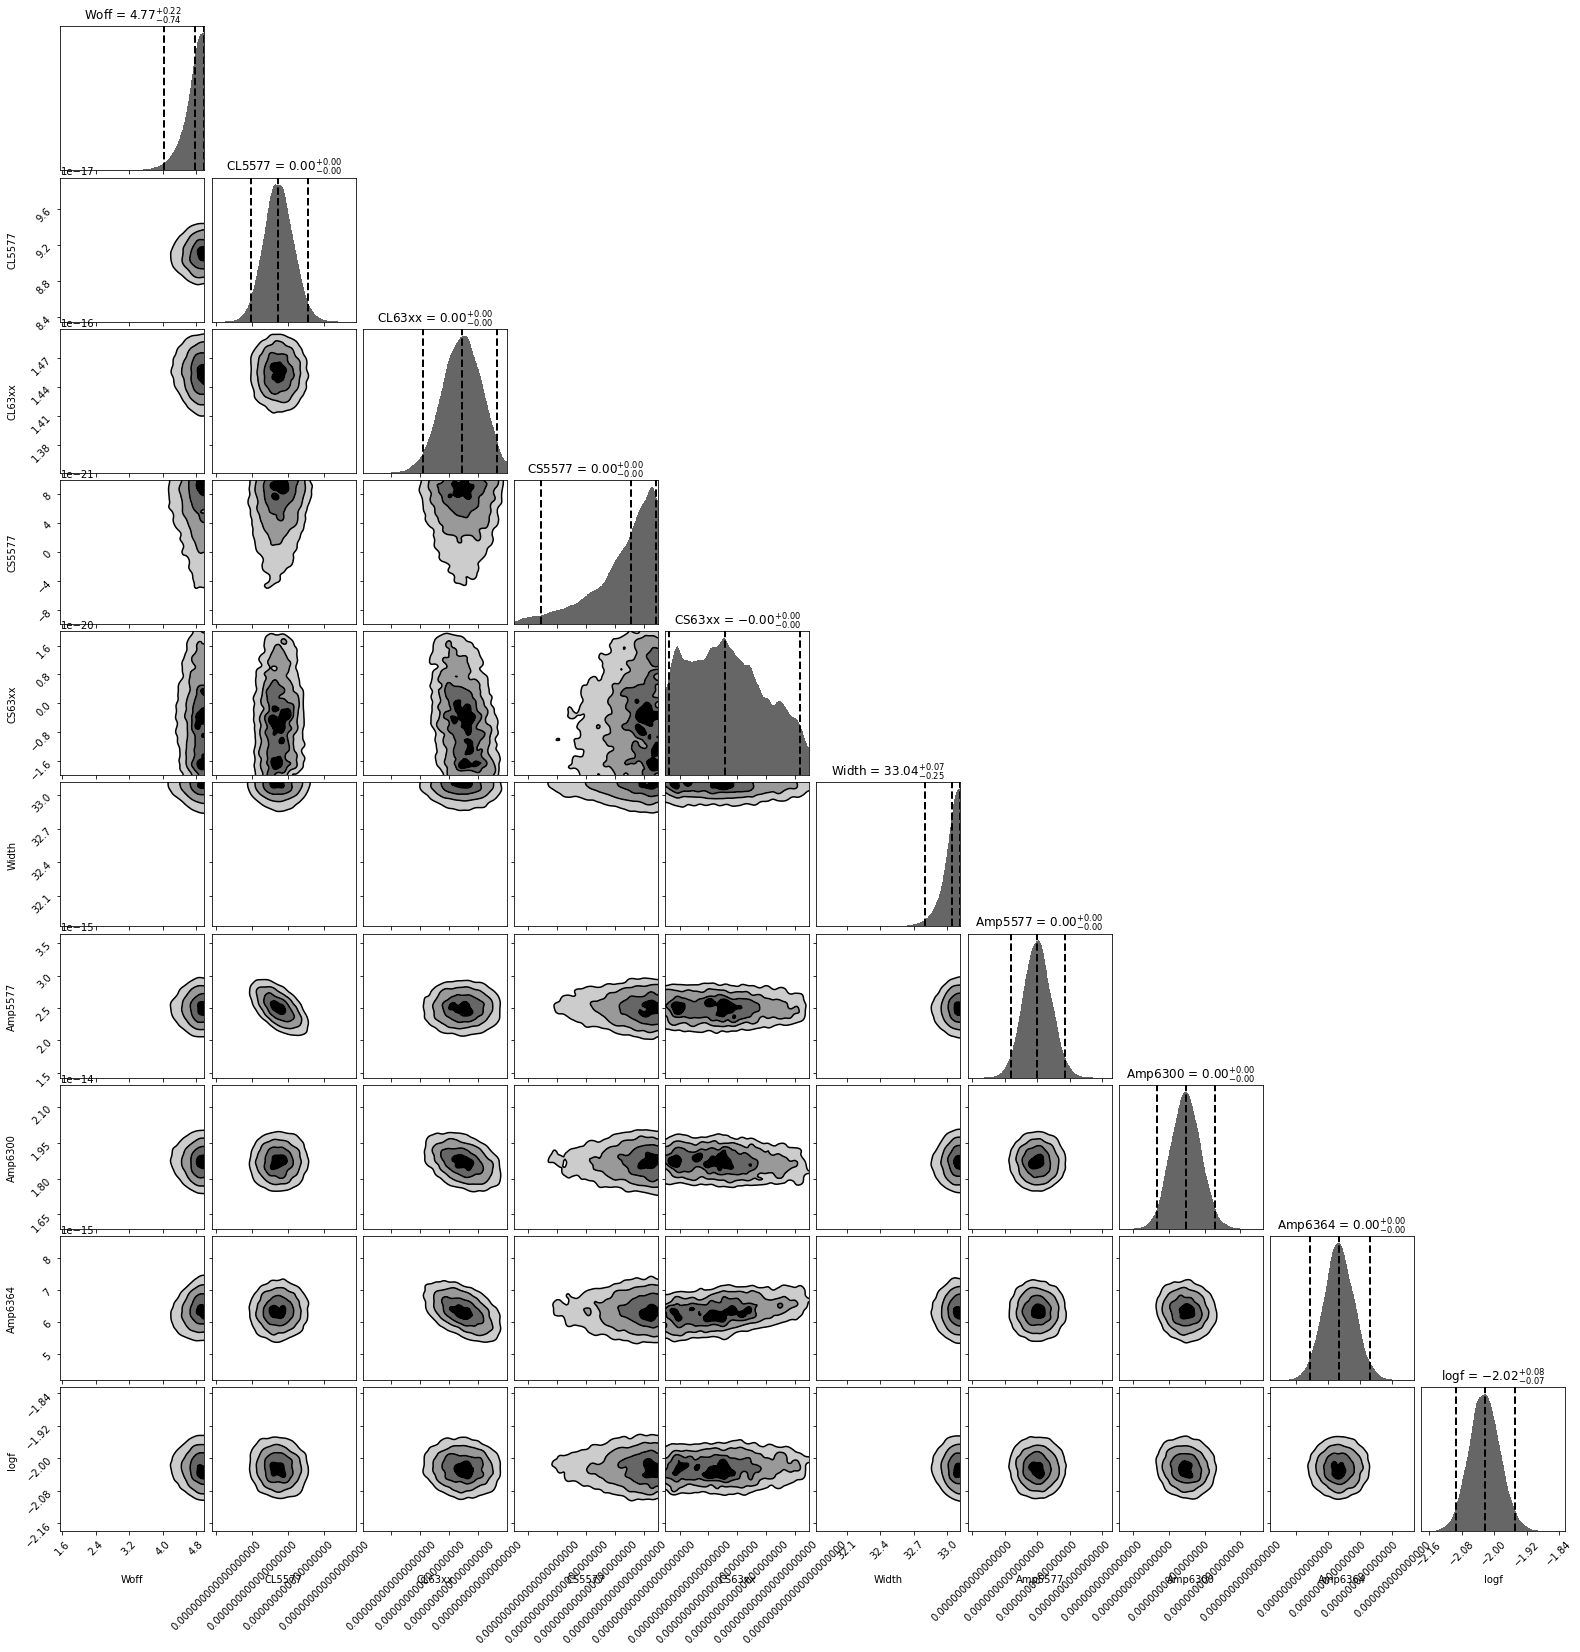

In [6]:
results = sampler.results
LABELS = ['Woff', 'CL5577', 'CL63xx', 'CS5577', 'CS63xx', 'Width', 'Amp5577', 'Amp6300', 'Amp6364', 'logf']
_=dyplot.cornerplot(results, labels=LABELS, show_titles=True)

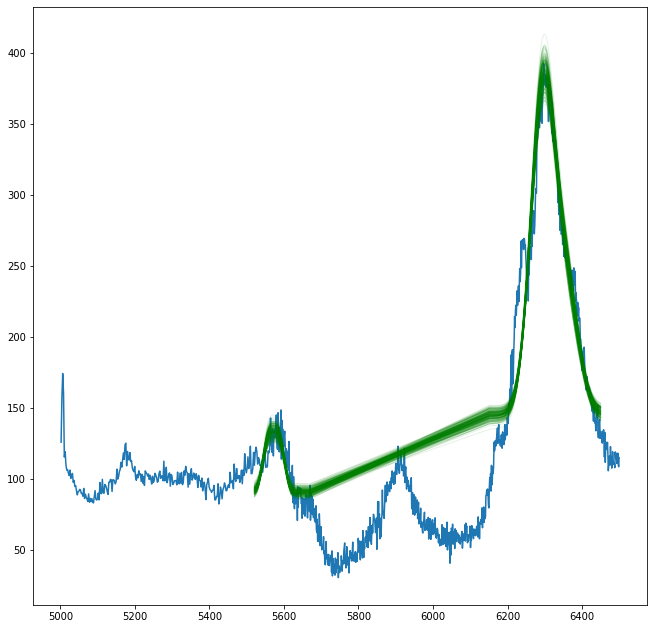

In [7]:
sf = cfg.scale_factor
fig,ax = plt.subplots(1, figsize=(11,11))

idx = np.logical_and(spec['restwave'] > 5000, spec['restwave'] < 6500)

ax.plot(spec['restwave'][idx], spec['flux'][idx]*sf)
oxygen_lines.plot_comparison(ax, cfg, sampler.results)

In [8]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
new_samples = dyfunc.resample_equal(samples, weights)
    
for i,l in [(6, 'A5577'), (7, 'A6300'), (8, 'A6364')]:
    t = new_samples[:,i]
    mean = np.nanmean(t)
    std = np.nanstd(t)
    print('%s %f \pm %f' % (l, np.log(mean), np.log(std)))

A5577 -33.620874 \pm -36.080219
A6300 -31.609764 \pm -35.015414
A6364 -32.690238 \pm -35.299970
